In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle
from pathlib import Path
from importlib import reload
from IPython.display import clear_output

from IEFC_modules import iefc_functions

from roman_cgi_iefc import cgi
from roman_cgi_iefc import iefc_sim as iefc
from roman_cgi_iefc import iefc_sim_2dm as iefc2

import misc

import proper
proper.prop_use_fftw(DISABLE=False)
proper.prop_fftw_wisdom( 1024 ) 

data_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')

# wavelength_c = 575e-9*u.m

# wavelength_ref = 0.5e-6*u.m
# pixelscale_lamD_ref = 1/2
# pixelscale_ref = 13e-6*u.m/u.pix
# pixelscale_lamD = pixelscale_lamD_ref * (wavelength_ref/wavelength_c)

# wavelength = 575e-9*u.m
# npsf = 64
# psf_pixelscale = 13e-6*u.m/u.pix
# psf_pixelscale_lamD = pixelscale_lamD * (psf_pixelscale/pixelscale_ref)
# print(psf_pixelscale_lamD)

flatmaps_dir = Path.home()/'src/pyfalco/roman/flatmaps'

dm1_flatmap = fits.getdata(flatmaps_dir/'dm1_m_flat_hlc_band1.fits')
dm2_flatmap = fits.getdata(flatmaps_dir/'dm2_m_flat_hlc_band1.fits')
dm1_design = fits.getdata(flatmaps_dir/'dm1_m_design_hlc_band1.fits')
dm2_design = fits.getdata(flatmaps_dir/'dm2_m_design_hlc_band1.fits')

Computing wisdom for 8 threads
Computing wisdom for 1 threads


# Initialize mode

In [3]:
reload(cgi)

hlci = cgi.CGI_PROPER(use_opds=False, use_fieldstop=False, quiet=True)
npsf = hlci.npsf
Nact = hlci.Nact

# hlci.set_dm1(dm1_flatmap)
# hlci.set_dm2(dm2_flatmap)

# psf = hlci.calc_psf()
# misc.myimshow2(psf, psf, lognorm1=True, lognorm2=True, 
#                pxscl1=hlci.psf_pixelscale, pxscl2=hlci.psf_pixelscale_lamD)

# Create dark hole ROI to calibrate and control

(4096,) (4096,) (4096,) (4096,)


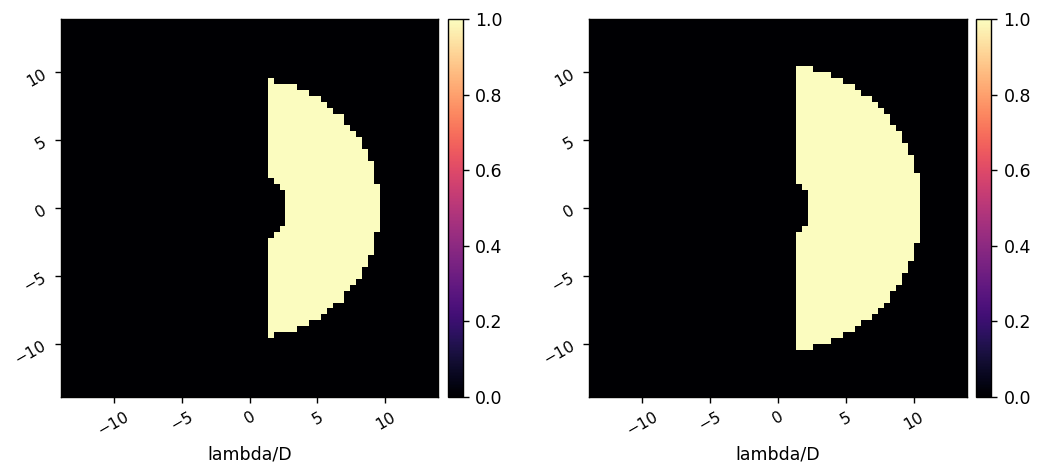

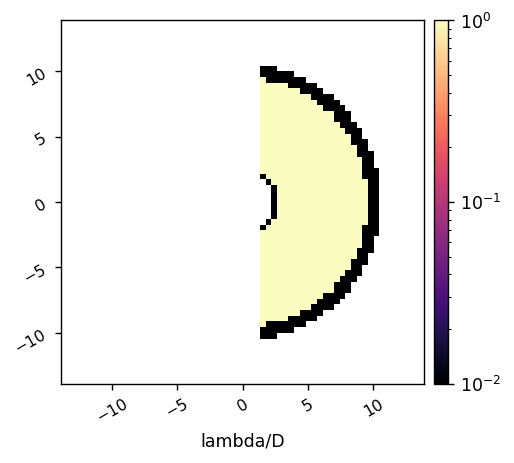

In [5]:
reload(iefc2)
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * hlci.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 1.5
iwa = 2.8
owa = 9.7

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x'
}
dh_mask = iefc2.create_dshaped_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa-0.5,
    'outer_radius' : owa+1,
    'edge_position' : edge,
    'direction' : '+x'
}
control_mask = iefc2.create_dshaped_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.99
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask

print(dh_mask.shape, control_mask.shape, control_mask.shape, weights.shape)
misc.myimshow2(dh_mask.reshape(npsf,npsf), control_mask.reshape(npsf,npsf), 
               pxscl1=hlci.psf_pixelscale_lamD, pxscl2=hlci.psf_pixelscale_lamD)
misc.myimshow(weights.reshape(npsf,npsf), lognorm=True, pxscl=hlci.psf_pixelscale_lamD)

# Create probe and fourier modes

Creating Fourier modes:  (64, 64)
(326, 2304) (2, 2304)


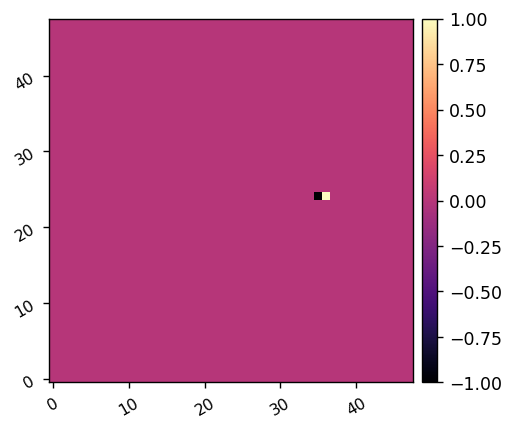

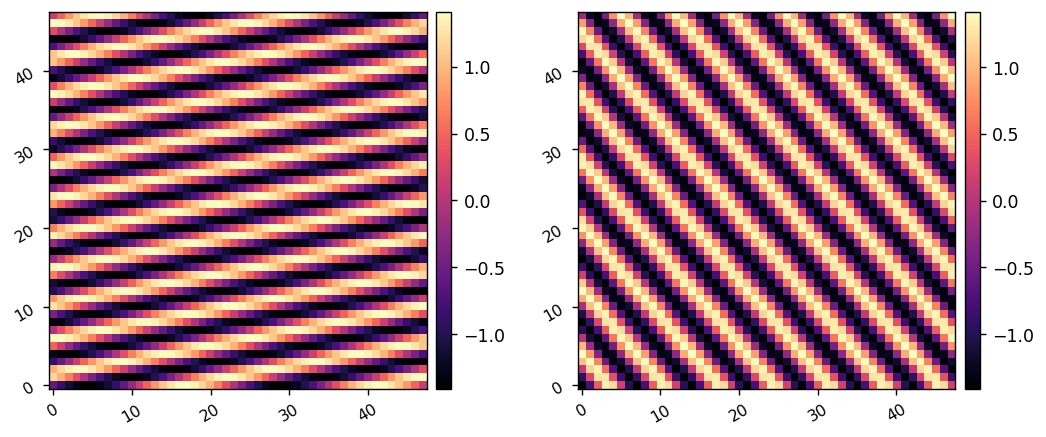

In [8]:
reload(iefc2)

fourier_modes, fx, fy = iefc2.create_fourier_modes(xfp, control_mask.reshape((npsf,npsf)), Nact, circular_mask=False)
probe_modes = iefc2.create_probe_poke_modes(hlci.Nact, 3*Nact//4, Nact//2, 3*Nact//4-1, Nact//2)

calibration_amplitude = 0.006 * hlci.wavelength.to(u.m).value
probe_amplitude = 0.05 * hlci.wavelength.to(u.m).value

print(fourier_modes.shape, probe_modes.shape)
misc.myimshow((probe_modes[0] - probe_modes[1]).reshape((Nact,Nact)))
misc.myimshow2(fourier_modes[0].reshape((Nact,Nact)), fourier_modes[300].reshape((Nact,Nact)))

# Testing

In [22]:
response_cube = fits.getdata(data_dir/'response-data'/'hlc_response_cube_ann_mask_2.fits')
calibration_cube = fits.getdata(data_dir/'calibration-data'/'hlc_calibration_cube_ann_mask_2.fits')
print(response_cube.shape, calibration_cube.shape)

# the response cube has shape (n_modes, 2, npsf**2)

(326, 2, 4096) (652, 4, 4096)


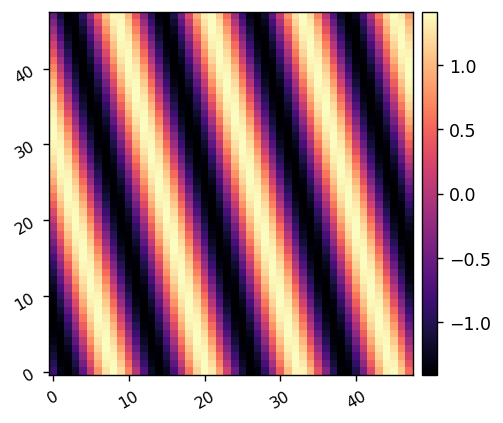

In [23]:
calibration_mode = fourier_modes[250]

misc.myimshow(calibration_mode.reshape(Nact,Nact))

In [12]:

slopes = []
images_1 = []
images_2 = []
    
slope_1, slope_2 = (0, 0)
for s in [-1, 1]: # We need a + and - probe to estimate the jacobian
    # DM1: Set the DM to the correct state
    hlci.add_dm1(s * calibration_amplitude * calibration_mode)
    differential_images_1, single_images_1 = iefc2.take_measurement(hlci, probe_modes, probe_amplitude, return_all=True)

    slope_1 += s * differential_images_1 / (2 * calibration_amplitude)
    images_1.append(single_images_1)

    hlci.add_dm1(-s * calibration_amplitude * calibration_mode) # remove the calibrated mode from DM1

    # DM2: Set the DM to the correct state
    hlci.add_dm2(s * calibration_amplitude * calibration_mode)
    differential_images_2, single_images_2 = iefc2.take_measurement(hlci, probe_modes, probe_amplitude, return_all=True)

    slope_2 += s * differential_images_2 / (2 * calibration_amplitude)
    images_2.append(single_images_2)

    hlci.add_dm2(-s * calibration_amplitude * calibration_mode) # remove the calibrated mode from DM2


In [25]:
slope_1.shape, differential_images_1.shape, single_images_1.shape

((2, 4096), (2, 4096), (4, 4096))

In [29]:
2**(3/4)/3**.5

0.9709835434146469

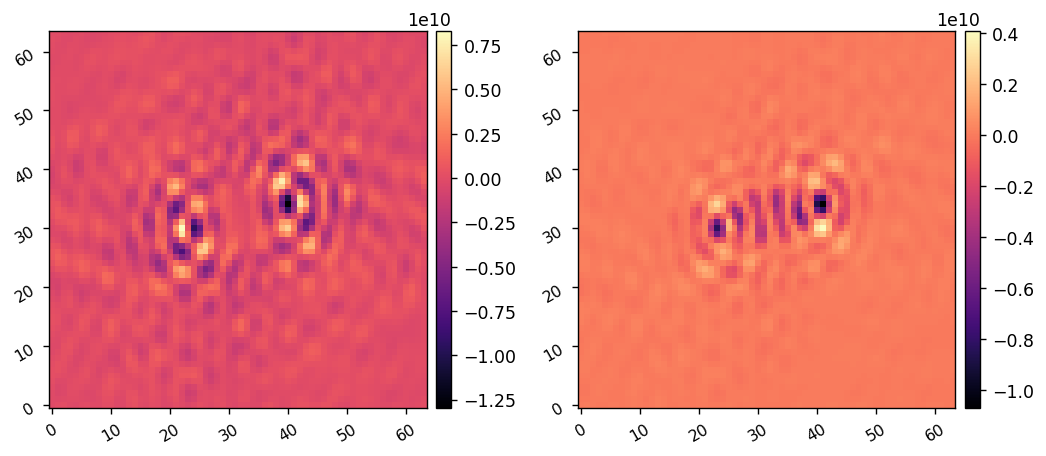

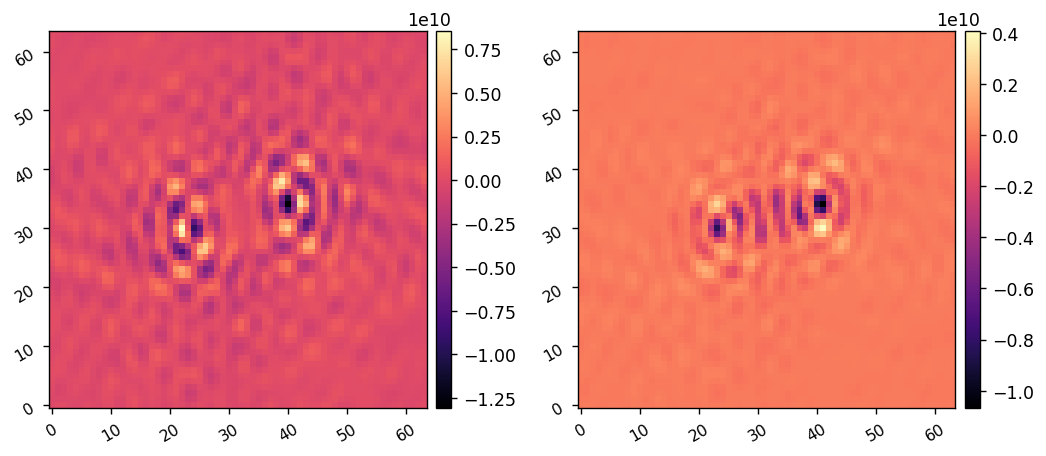

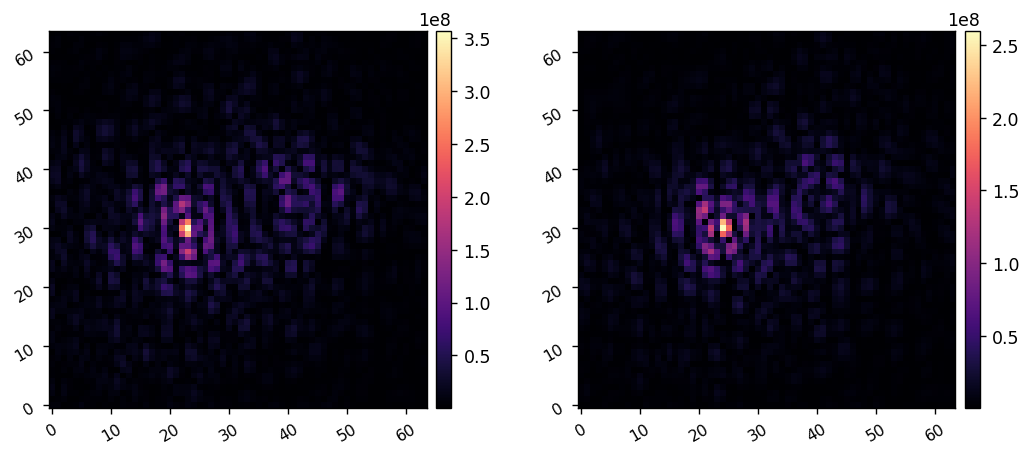

In [27]:
misc.myimshow2(slope_1[0].reshape(npsf,npsf), slope_1[1].reshape(npsf,npsf))
misc.myimshow2(slope_2[0].reshape(npsf,npsf), slope_2[1].reshape(npsf,npsf))
misc.myimshow2(np.abs(slope_1[0]-slope_2[0]).reshape(npsf,npsf), 
               np.abs(slope_1[1]-slope_2[1]).reshape(npsf,npsf))


# Calibrate IEFC (or load in previous calibration data)

In [ ]:
reload(iefc_sim)

response_cube, calibration_cube = iefc_sim.calibrate(hlci, probe_amplitude, probe_modes, 
                                                     calibration_amplitude, fourier_modes, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 326 in 22.868s
	Calibrated mode 2 / 326 in 45.835s


In [24]:
print(response_cube.shape, calibration_cube.shape)

response_hdu = fits.PrimaryHDU(data=response_cube)
response_hdu.writeto(data_dir/'response-data'/'hlc_response_cube_ann_mask.fits', overwrite=True)

calib_hdu = fits.PrimaryHDU(data=calibration_cube)
calib_hdu.writeto(data_dir/'calibration-data'/'hlc_calibration_cube_ann_mask.fits', overwrite=True)

(300, 2, 4096) (600, 4, 4096)


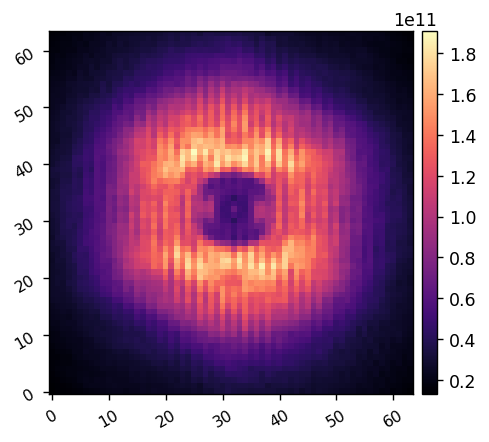

In [5]:
im = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(im.reshape(64,64))